In [1]:
from osgeo import gdal
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def read_image_gray(filepath):
    gray = gdal.Open(filepath)
    assert gray.RasterCount == 1, 'Must be grayscale image'
    x = gray.RasterXSize  # 列
    y = gray.RasterYSize  # 行
    
    return gray.ReadAsArray()[:y, :x], gray.GetGeoTransform(), gray.GetProjection()

def save_tif(img, path, gt, prj):  # 将图像保存为tif并写入投影信息
    driver = gdal.GetDriverByName('GTiff')
    if len(img.shape) == 2:
        img = img.reshape((img.shape[0], img.shape[1], 1))
    data_type = gdal.GDT_Byte if img.dtype == 'np.uint8' or img.dtype == 'bool' else gdal.GDT_Float32
    dataset = driver.Create(path, img.shape[1], img.shape[0], img.shape[2], data_type)
    dataset.SetGeoTransform(gt)
    dataset.SetProjection(prj)
    for i in range(img.shape[2]):
        dataset.GetRasterBand(i + 1).WriteArray(img[:, :, i])
    del dataset

def conver_to_uint8(img, percentile = False):
    if percentile:
        min_per = 0 if img.dtype == 'int16' else 0.3
        max_per = 100 - min_per
        cut_min = np.nanpercentile(img.ravel(), min_per) #ravel()方法将数组维度拉成一维数组
        cut_max = np.nanpercentile(img.ravel(), max_per)
        img = np.clip(img, cut_min, cut_max) #去除最大最小值
    else:
        cut_min = img.min()
        cut_max = img.max()
    
    img_uint8 = (255 * (img - cut_min) / (cut_max - cut_min)).astype(np.uint8)  # img.astype(np.uint8)
    return img_uint8

1162 6
(1024, 1024, 3)


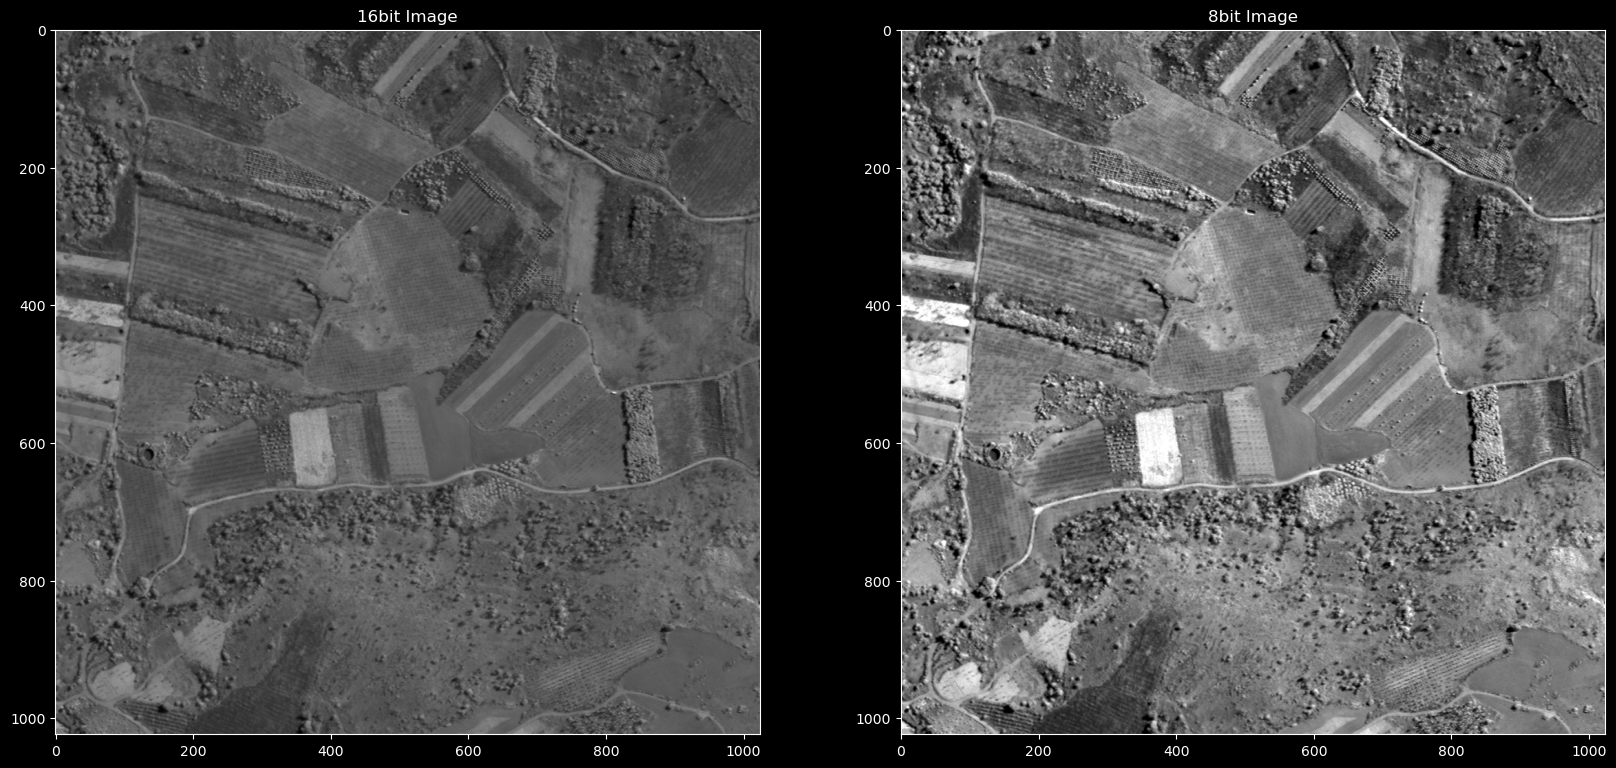

In [3]:
left_16, gt, prj = read_image_gray('./left/KM_left_1.tiff')
print(left_16.max(), left_16.min())

left_8 = conver_to_uint8(left_16, percentile=True)

# left_8 = cv2.cvtColor(left_8, cv2.COLOR_GRAY2BGR)

print(left_8.shape)

f, axis = plt.subplots(1, 2, figsize = (20,60))
axis[0].imshow(left_16, cmap='gray')
axis[0].set_title('16bit Image')
axis[1].imshow(left_8, cmap='gray')
axis[1].set_title('8bit Image')
plt.show()

In [5]:
# save_tif(left_8, './test_8bit.png', gt, prj)
cv2.imwrite('./test_8bit.png', left_8)

True